In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Lecture 3C - Group By, Aggregation Operations and Shaping Data*
---


### Content

1. Group-by operations
2. Pivot tables
3. Cross tabulation

 

\* Content in this notebook is based on the material in the "Python for Data Analysis" book by Wes McKinney, chapter 9.

### Learning Outcomes

At the end of this lecture, you should be able to:

* explain the group by mechanism
* split pandas objects into groups using one or more keys
* compute group summary statistics
* perform cross tabulation
* generate pivot tables

---

In [2]:
from IPython.display import HTML, IFrame
IFrame("http://pandas.pydata.org/pandas-docs/dev/groupby.html", width=1100, height=500)



Categorizing a data set and applying operations to each group, be it **transformations or aggregations, is frequently a critical component of a data analysis workflow**. 

After loading, merging, and preparing a data set, a **common task is to compute group statistics or possibly pivot tables for reporting or visualization purposes**. 

**Pandas provides a flexible and high-performance groupby facility**, enabling you to slice and dice, and summarize data sets in a natural way.

One reason for the popularity of relational databases and SQL (which stands for “structured query language”) is the **ease with which data can be joined, filtered, transformed, and aggregated**. However, query languages like **SQL suffer from limitations in the kinds of group operations that can be performed**. 

With the expressiveness and power of Python and pandas, **much more complex grouping operations can be executed** by utilizing any function that accepts a pandas object or NumPy array.

Most off-the-shelf software like Excel can to some degree perform operations like pivot tables that are immensely valued. However, Excel has serious limitations. The greatest of these is memory. Even that latest Excel suite can only handle up to 1M rows but not more (using the PowerPivot add-on, this can now be extended). Pandas provided the **ability to flexibly handle millions of rows of spreadsheet data up to the maximum capacity of your PC's on board RAM**. 

# 1. Group-By operations

One of the most powerful features of Pandas is its **GroupBy** functionality. On occasion we may want to perform operations on *groups* of observations within a dataset. For example:

* **aggregation**, such as computing the sum of mean of each group, which involves applying a function to each group and returning the aggregated results
* **slicing** the DataFrame into groups and then doing something with the resulting slices (*e.g.* plotting)
* group-wise **transformation**, such as standardization/normalization

A common data analysis procedure is the **split-apply-combine** operation, which **groups subsets of data together, applies a function to each of the groups, then recombines them into a new data table**.

For example, we may want to aggregate our data with with some function.

![split-apply-combine](http://f.cl.ly/items/0s0Z252j0X0c3k3P1M47/Screen%20Shot%202013-06-02%20at%203.04.04%20PM.png)

<div align="right">*(figure source "Python for Data Analysis", p.252)*</div>

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams

%matplotlib inline

In [4]:
# Set some Pandas options as you like
pd.set_option('max_columns', 40)
pd.set_option('max_rows', 30)

In [5]:
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 20

In [6]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-0.204625,0.210392
1,a,two,2.602174,0.165849
2,b,one,0.690278,-1.321196
3,b,two,1.653179,0.065525
4,a,one,-0.261774,1.483877


Suppose you wanted to compute the mean of the data1 column using the grouped labels
from key1. There are a number of ways to do this. One is to slice data1 and call
groupby with the column (a Series) at key1:

In [7]:
grouped = df['data1'].groupby(df['key1'])
grouped

This grouped variable is now a GroupBy object. It has not actually computed anything
yet except for some intermediate data about the group key df['key1']. 

The idea is that this object has all of the information needed to then apply some operation to each of
the groups. 

We can find out what groups we have and who is in these groups by index:

In [8]:
grouped.groups

{'a': Int64Index([0, 1, 4], dtype='int64'),
 'b': Int64Index([2, 3], dtype='int64')}

### Iterating over groups

In order to inspect which rows have been associated with grouping values, we need to iterate through each group.

In [9]:
for key, value in grouped:
    print(key, type(value))
    print(value)

a <class 'pandas.core.series.Series'>
0   -0.204625
1    2.602174
4   -0.261774
Name: data1, dtype: float64
b <class 'pandas.core.series.Series'>
2    0.690278
3    1.653179
Name: data1, dtype: float64


Now that we have our groupings, we can compute operations on groups using various pre-defined methods or built in methods. Here is the example of applying means to each group:

In [10]:
grouped.mean()

key1
a    0.711925
b    1.171728
Name: data1, dtype: float64

We could have taken a shortcut and calculated the mean and returned a Series object:

In [11]:
df['data1'].groupby(df['key1']).mean()

key1
a    0.711925
b    1.171728
Name: data1, dtype: float64

or alternatively:

In [12]:
df[['data1','key1']].groupby('key1').count()

,data1
key1,
a,3
b,2


**Exercise**: Perform group by on 'key2' and calculate the sum of values on the 'data2' column. 

In [13]:
df[['data2','key2']].groupby('key2').sum()

,data2
key2,
one,0.373073
two,0.231374


**Exercise:** Using df above, display the result of a group by operation on key1, showing the count/number of values that have been aggregated:

In [14]:
a=  df.groupby('key1').count()
a

,key2,data1,data2
key1,,,
a,3,3,3
b,2,2,2


We sometimes want to perform group by operations on all columns in  a data frame, whilst grouping the data on one or more columns. This can be done as follows:

In [15]:
df

,key1,key2,data1,data2
0,a,one,-0.204625,0.210392
1,a,two,2.602174,0.165849
2,b,one,0.690278,-1.321196
3,b,two,1.653179,0.065525
4,a,one,-0.261774,1.483877


In [16]:
gr = df.groupby('key1').mean()
gr

,data1,data2
key1,,
a,0.711925,0.620039
b,1.171728,-0.627836


Notice that the returned object in this instance is a data frame since we made use of all columns, and that 'key2' column is ignored since a mean on it cannot be performed.

### Applying multiple operations on groups


Pandas comes with a number of built-in and optimised operations which can be applied simultaneously to the groups using the  `agg` function.

Optimized groupby methods:    

**Function name Description**
- count = Number of non-NA values in the group
- sum = Sum of non-NA values
- mean = Mean of non-NA values
- median = Arithmetic median of non-NA values
- std, var = Unbiased (n - 1 denominator) standard deviation and variance
- min, max = Minimum and maximum of non-NA values
- prod  = Product of non-NA values
- first, last = First and last non-NA values

- In addition we can define our own functions to apply to groups

In [17]:
def my_length(x):
    return len(x)

In [18]:
grouped = df.groupby('key1')
result = grouped.agg(['sum','count','mean','median','min','max','std','var', my_length])
result

data1                                                          \
           sum count      mean    median       min       max       std   
key1                                                                     
a     2.135775     3  0.711925 -0.204625 -0.261774  2.602174  1.637253   
b     2.343457     2  1.171728  1.171728  0.690278  1.653179  0.680874   

                             data2                                      \
           var my_length       sum count      mean    median       min   
key1                                                                     
a     2.680598       3.0  1.860118     3  0.620039  0.210392  0.165849   
b     0.463589       2.0 -1.255671     2 -0.627836 -0.627836 -1.321196   

                                              
           max       std       var my_length  
key1                                          
a     1.483877  0.748437  0.560158       3.0  
b     0.065525  0.980560  0.961497       2.0

As seen from the above example, we can define our own functions and apply them to the groups:

In [19]:
grouped.apply(my_length)

key1
a    3
b    2
dtype: int64

In [20]:
grouped

### Grouping on multiple columns

We could also perform group by on multiple columns:

In [21]:
df

,key1,key2,data1,data2
0,a,one,-0.204625,0.210392
1,a,two,2.602174,0.165849
2,b,one,0.690278,-1.321196
3,b,two,1.653179,0.065525
4,a,one,-0.261774,1.483877


In [22]:
grouped = df.groupby(['key1','key2'])
grouped.groups

{('a', 'one'): Int64Index([0, 4], dtype='int64'),
 ('a', 'two'): Int64Index([1], dtype='int64'),
 ('b', 'one'): Int64Index([2], dtype='int64'),
 ('b', 'two'): Int64Index([3], dtype='int64')}

Notice that in this case we do not end up with a simple index. What we end up with here is what is called a **hierarchical index**. Each row then becomes accessible using the combination of the two indexes:

In [23]:
grouped.groups['a','one']

Int64Index([0, 4], dtype='int64')

We can use these index values to access the actual values in the original dataframe

In [24]:
df.iloc[grouped.groups['a','one']]

,key1,key2,data1,data2
0,a,one,-0.204625,0.210392
4,a,one,-0.261774,1.483877


We now create a new dataframe that has the mean values of all the groups

In [27]:
df_grouped = grouped.mean()
df_grouped

data1     data2
key1 key2                    
a    one  -0.233200  0.847135
     two   2.602174  0.165849
b    one   0.690278 -1.321196
     two   1.653179  0.065525

Make a quick plot of this data:

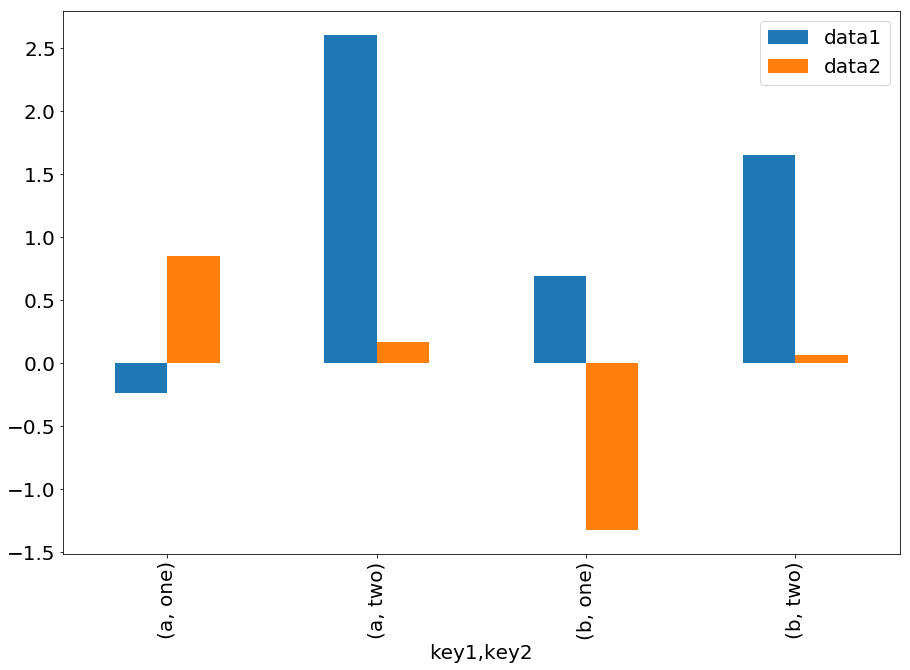

In [28]:
df_grouped.plot(kind='bar')

### Shaping and reshaping data with **hierarchical indexes**

Hierarchical indexes are created when we group data frames using multiple columns. They are very useful as they allow us to reshape our data.

Consider the dataframe object which was generated from the example above:

In [29]:
df_grouped

data1     data2
key1 key2                    
a    one  -0.233200  0.847135
     two   2.602174  0.165849
b    one   0.690278 -1.321196
     two   1.653179  0.065525

In order to  reshape data (hierarchically structured dataframes) we have functions **`stack`** and **`unstack`** available to us.

        stack: “pivot” a level of the (possibly hierarchical) column labels, returning a DataFrame with an index with a new 
        inner most level of row labels.
        
        unstack: inverse operation from stack: “pivot” a level of the (possibly hierarchical) row index to the column axis, 
        producing a reshaped DataFrame with a new inner-most level of column labels.

The above dataframe is already `stacked` which is indicated by the second index indicating hierarchical indexing. We can stack it one further level by taking the columns and making them into columns:

In [31]:
stacked_df = df_grouped.stack()
pd.DataFrame(stacked_df)

0
key1 key2                
a    one  data1  0.368163
          data2  0.207635
     two  data1  1.660063
          data2 -0.825212
b    one  data1  1.115914
          data2 -1.144263
     two  data1 -0.952247
          data2  1.544840

In [32]:
df_grouped

data1     data2
key1 key2                    
a    one   0.368163  0.207635
     two   1.660063 -0.825212
b    one   1.115914 -1.144263
     two  -0.952247  1.544840

Alternatively, we can unstack the original dataframe by taking the inner-most index ('key2') and moving it into the column axis:

In [33]:
unstacked_df = df_grouped.unstack()
unstacked_df

data1               data2          
key2       one       two       one       two
key1                                        
a     0.368163  1.660063  0.207635 -0.825212
b     1.115914 -0.952247 -1.144263  1.544840

In [34]:
df_grouped

data1     data2
key1 key2                    
a    one   0.368163  0.207635
     two   1.660063 -0.825212
b    one   1.115914 -1.144263
     two  -0.952247  1.544840

We can slice into dataframes and perform stacking/unstacking on selected columns:

In [35]:
s = df_grouped['data1']
s

key1  key2
a     one     0.368163
      two     1.660063
b     one     1.115914
      two    -0.952247
Name: data1, dtype: float64

The above is now a series object having a hierarchical index which we can now reshape into a data frame with the help of `unstack` method:

In [36]:
df2 = s.unstack()
df2

key2,one,two
key1,,
a,0.368163,1.660063
b,1.115914,-0.952247


**Exercise**: Stack the df_grouped dataframe so that data1 and data2 now become rows and store this result in a new dataframe. Now unstack this new dataframe by making key1 into columns. Look up the function to see how you can specify which row to unstack explicitly.

#### Removing hierarchical indexes from group by operations

Sometimes we do not want to preserve the hierarchical index. We can stop the group by operation from generating it by setting the as_index argument to False:

In [37]:
df

,key1,key2,data1,data2
0,a,one,0.945839,-1.445431
1,a,two,1.660063,-0.825212
2,b,one,1.115914,-1.144263
3,b,two,-0.952247,1.544840
4,a,one,-0.209513,1.860700


In [38]:
df_grouped_mean = df.groupby(['key1','key2'], as_index=False).mean()
df_grouped_mean

,key1,key2,data1,data2
0,a,one,0.368163,0.207635
1,a,two,1.660063,-0.825212
2,b,one,1.115914,-1.144263
3,b,two,-0.952247,1.544840


Or...

In [39]:
df.groupby(['key1','key2']).mean().reset_index()

,key1,key2,data1,data2
0,a,one,0.368163,0.207635
1,a,two,1.660063,-0.825212
2,b,one,1.115914,-1.144263
3,b,two,-0.952247,1.544840


---

---

# 2. Pivot Tables

A **pivot table is a data summarization tool** that is very much like the group by facility (and is actually powered by pandas group by under the hood). This tool/operation is routinely performed in spreadsheet programs and other data analysis software. It aggregates a table of data by one or more keys, arranging the data in a rectangle with some of the group keys along the rows and some along the columns. Pivot is often regarded as one of Excels greatest strengths.

Pandas' groupby facility enables pivot table functionality, together with the reshape operations utilizing hierarchical indexing seen earlier. 

DataFrame has a  dedicated pivot_table method, and additionally there is a top-level  pandas.pivot_table function. 

To illustrate these features, a less trivial dataset on restaurant tipping will be used called "tips.csv". It is from the R  reshape2 package; it was originally found in Bryant & Smith’s 1995 text on business statistics (and found in the book’s GitHub repository).

In [40]:
df_tips = pd.read_csv("../datasets/tips.csv")
df_tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_percent
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


Suppose we wanted to compute a table of group means (the default  pivot_table aggregation type) arranged by  sex and  smoker on the rows:

In [41]:
df_tips.pivot_table(index=['sex', 'smoker'])

size       tip  tip_percent  total_bill
sex    smoker                                             
Female No      2.592593  2.773519     0.156921   18.105185
       Yes     2.242424  2.931515     0.182150   17.977879
Male   No      2.711340  3.113402     0.160669   19.791237
       Yes     2.500000  3.051167     0.152771   22.284500

In [42]:
df_tips.pivot_table(index=['smoker', 'sex'])

size       tip  tip_percent  total_bill
smoker sex                                                
No     Female  2.592593  2.773519     0.156921   18.105185
       Male    2.711340  3.113402     0.160669   19.791237
Yes    Female  2.242424  2.931515     0.182150   17.977879
       Male    2.500000  3.051167     0.152771   22.284500

This could have been easily produced using  groupby as well.

**Exercise:** Perform the above using groupby.

In [67]:
n_df_tips = df_tips.groupby(['sex','smoker']).mean()
# n_df_tips = n_df_tips.mean()
n_df_tips

total_bill       tip      size  tip_percent
sex    smoker                                             
Female No       18.105185  2.773519  2.592593     0.156921
       Yes      17.977879  2.931515  2.242424     0.182150
Male   No       19.791237  3.113402  2.711340     0.160669
       Yes      22.284500  3.051167  2.500000     0.152771

However, as the perspective which you would like to view data from becomes more complex, additional constructs become helpful.

Now, suppose we want to aggregate only tip_percent and table-party size and we want these aggregations to be split between those who are smokers and non-smokers. And suppose we want to additionally group by day as well as sex. 

In [68]:
df_tips.pivot_table(values=['tip_percent', 'size'], index=['sex', 'day'], columns='smoker')

size           tip_percent          
smoker             No       Yes          No       Yes
sex    day                                           
Female Fri   2.500000  2.000000    0.165296  0.209129
       Sat   2.307692  2.200000    0.147993  0.163817
       Sun   3.071429  2.500000    0.165710  0.237075
       Thur  2.480000  2.428571    0.155971  0.163073
Male   Fri   2.000000  2.125000    0.138005  0.144730
       Sat   2.656250  2.629630    0.162132  0.139067
       Sun   2.883721  2.600000    0.158291  0.173964
       Thur  2.500000  2.300000    0.165706  0.164417

**Exercise:** Create a pivot table that aggregates by mean only tip_percent and we want these aggregations to be split between dinner and lunches. And  we would like to group by sex and smoker. 

In [72]:
df_tips.pivot_table(values=['tip_percent'], index=['sex', 'time'], columns='smoker')

tip_percent          
smoker                 No       Yes
sex    time                        
Female Dinner    0.156774  0.185142
       Lunch     0.157091  0.175270
Male   Dinner    0.159360  0.148929
       Lunch     0.165706  0.166662

Mean is the default operation performed with pivot tables. Other functions can be used, for example 'len'

In [44]:
df_tips.pivot_table(values='tip_percent', index=['sex', 'smoker'], columns='day', aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
sex    smoker                               
Female No       2.0  13.0  14.0  25.0   54.0
       Yes      7.0  15.0   4.0   7.0   33.0
Male   No       2.0  32.0  43.0  20.0   97.0
       Yes      8.0  27.0  15.0  10.0   60.0
All            19.0  87.0  76.0  62.0  244.0

**Exercise:** Create a pivot table that sums up the total bills for each daya and splits them by smoker.

---

---

# 3. Cross-Tabulation

A cross-tabulation (or crosstab for short) is a special case of a pivot table that computes
group frequencies.

The first two arguments to  crosstab can each either be an array or Series or a list of
arrays. As in the tips data:

In [45]:
pd.crosstab([df_tips.time, df_tips.day], df_tips.smoker)

smoker       No  Yes
time   day          
Dinner Fri    3    9
       Sat   45   42
       Sun   57   19
       Thur   1    0
Lunch  Fri    1    6
       Thur  44   17

**Exercise:** Cross-tabulate the tips data in order count the number of tips for dinner and lunches, while grouping by sex and smoker and showing all the margins too. 

---

---

# Exercises

Exercises below will use a geographic dataset sourced from http://www.geonames.org/countries/ called "country_info.csv".

Load the above dataset into a dataframe and inspect the data.

Use this dataset to answer the exercises below.

**Exercise** Group the dataset by continent, showing the total population in each one. Plot the result.

**Exercise** Group the dataset by CurrencyName, showing the total surface Area that each one covers. Sort the result by size and display the top ten currencies by land surface area. Plot the result.

**Exercise** Perform the same aggregation as above, this time using Population instead of land Area.

**Exercise** Use the pivot table to display information for currencies in Europe only. Group the data by continent and currency name, showing only the results from Europe. Aggregate by using summation for the Area and the Population variables and show the margins.

**Exercise**: Cross-tabulate the dataset to find out the counts for currency names across Europe and Americas together with the margins.

**Exercise**: On the Stream site, you will find links to a number of repositories. 

1. Go through these repositories and identify two datasets which you can practice merging and concatenating on.
2. Apply appropriate group by operations on this data in order to draw out insights
3. Apply combinations of appropriate group by operations as well as pivots and cross-tabulation on this data in order to draw out insights.